<center><h1>New York City Taxi Fare Prediction</h1>
    <h3>Projet Big Data</h3>
<h6>Flora Fevrier / Gabriel Foret / Paul Debuire / Alban Daniel / Solène Lemas</h6></center>
<hr/>

In [265]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import des packages

In [266]:
import pandas as pd
from geopy.distance import geodesic
import math
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon, Polygon
import holidays
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
import seaborn as sb
from datetime import datetime, timedelta
import pytz

# Import des données

In [267]:
# Spécifiez le chemin vers votre fichier CSV
chemin_du_fichier_csv = '/content/drive/MyDrive/Projet BIG DATA/train.csv'

# Spécifiez la taille des échantillons
taille_de_lechantillon = 100000
taille_ech_import = 200000

# Spécifiez une graine aléatoire (vous pouvez utiliser n'importe quel nombre entier)
graine_aleatoire = 2

# Utilisez le paramètre nrows pour importer uniquement les premières lignes du fichier
taxi_initial = pd.read_csv(chemin_du_fichier_csv, nrows=taille_ech_import)

# Ensuite, utilisez sample pour extraire l'échantillon aléatoire
taxi_test = taxi_initial.sample(n=taille_de_lechantillon, random_state=graine_aleatoire)

In [268]:
taxi_test.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
105775,2011-11-17 19:10:53.0000003,6.1,2011-11-17 19:10:53 UTC,-73.973295,40.743817,-73.986726,40.740075,1
13154,2010-02-28 08:46:06.0000001,4.1,2010-02-28 08:46:06 UTC,-73.999379,40.733547,-73.987801,40.728375,1
181761,2009-12-24 12:07:35.0000003,9.3,2009-12-24 12:07:35 UTC,-73.981620,40.778520,-73.954428,40.763992,1
191939,2015-01-20 23:15:33.0000002,7.5,2015-01-20 23:15:33 UTC,-74.004341,40.747765,-73.991211,40.735119,1
149011,2009-05-23 17:29:00.000000151,6.9,2009-05-23 17:29:00 UTC,-73.962005,40.767942,-73.954818,40.788557,1


In [269]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 100000  individus et  8  variables.


In [399]:
# Import des monuments

monuments = pd.read_csv('/content/drive/MyDrive/Projet BIG DATA/monuments.csv', sep = '\t')
monuments.head()

,Monument,Longitude,Latitude
0,JFK Airport,-73.780526,40.648823
1,LaGuardia Airport,-73.875195,40.779340
2,Empire State Building,-73.985796,40.750383
3,Times Square,-73.985781,40.758863
4,Dumbo,-73.989523,40.703502


In [271]:
# Import des données des quartiers de New York

#lieux = gpd.read_file('/content/drive/MyDrive/Projet BIG DATA/lieux.csv', sep = '\t')
#lieux.head()

In [401]:
# Import des fuel_price

fuel_price = pd.read_csv('/content/drive/MyDrive/Projet BIG DATA/Gasoline_Retail_Prices_Weekly_Average_by_Region__Beginning_2007.csv', sep = ',')

# Selection des prix uniquement de la ville de New York

selected_columns = ['Date', 'New York City Average ($/gal)']
fuel_price = fuel_price[selected_columns]

fuel_price.head()

,Date,New York City Average ($/gal)
0,01/29/2024,3.31
1,01/22/2024,3.31
2,01/15/2024,3.34
3,01/08/2024,3.36
4,01/01/2024,3.41


Le problème de notre df 'fuel_price', c'est qu'il contient les données des prix d'uniquement les lundis. Nous allons donc étendre le prix à la semaine entière

In [402]:
# Convertir la colonne 'Date' en datetime
fuel_price['Date'] = pd.to_datetime(fuel_price['Date'])

# Déterminer la date d'origine
start_date = fuel_price['Date'].max()

# Créer un DataFrame avec les dates étendues
extended_dates = pd.DataFrame(pd.date_range(start=start_date, periods=len(fuel_price)*7, freq='-1D'), columns=['Date_Extended'])

# Répéter la colonne 'New York City Average ($/gal)' pour chaque semaine
extended_dates['New York City Average ($/gal)'] = fuel_price['New York City Average ($/gal)'].repeat(7).reset_index(drop=True)

fuel_price = extended_dates

# Afficher le résultat
fuel_price.head()

,Date_Extended,New York City Average ($/gal)
0,2024-01-29,3.31
1,2024-01-28,3.31
2,2024-01-27,3.31
3,2024-01-26,3.31
4,2024-01-25,3.31


# Traitement des données manquantes et valeurs aberrantes

In [274]:
# nombre de NA par colonne
pd.isna(taxi_test).sum()
# 376 lignes avec données manquantes soit moins de 0,01 % de notre train

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [275]:
# suppression des lignes avec données manquantes : courses non terminées
taxi_test = taxi_test.dropna()

In [276]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 100000  individus et  8  variables.


In [277]:
# Convertissez la colonne pickup_datetime en type datetime
taxi_test['pickup_datetime'] = pd.to_datetime(taxi_test['pickup_datetime'])

# Définissez le fuseau horaire de destination (New York)
destination_timezone = pytz.timezone('America/New_York')

# Convertissez l'heure de pickup_datetime à l'heure de New York
taxi_test['pickup_datetime_ny'] = taxi_test['pickup_datetime'].dt.tz_convert(destination_timezone)

# Puis suppression de l'ancienne pickup_datetime
taxi_test = taxi_test.drop('pickup_datetime', axis=1)

In [278]:
# variable pickup_datetime_ny
# on récupère que la date
taxi_test['datedep']=taxi_test['pickup_datetime_ny'].dt.date

In [279]:
taxi_test['datedep'] = pd.to_datetime(taxi_test['datedep'], errors='coerce')

In [280]:
# on vérifie si données manquantes = mauvaise conversion donc mauvaise date
donnees_aberrantes = taxi_test[taxi_test['datedep'].isnull()]

In [281]:
donnees_aberrantes.shape

(0, 9)

In [282]:
taxi_test.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_ny,datedep
105775,2011-11-17 19:10:53.0000003,6.1,-73.973295,40.743817,-73.986726,40.740075,1,2011-11-17 14:10:53-05:00,2011-11-17
13154,2010-02-28 08:46:06.0000001,4.1,-73.999379,40.733547,-73.987801,40.728375,1,2010-02-28 03:46:06-05:00,2010-02-28
181761,2009-12-24 12:07:35.0000003,9.3,-73.981620,40.778520,-73.954428,40.763992,1,2009-12-24 07:07:35-05:00,2009-12-24
191939,2015-01-20 23:15:33.0000002,7.5,-74.004341,40.747765,-73.991211,40.735119,1,2015-01-20 18:15:33-05:00,2015-01-20
149011,2009-05-23 17:29:00.000000151,6.9,-73.962005,40.767942,-73.954818,40.788557,1,2009-05-23 13:29:00-04:00,2009-05-23


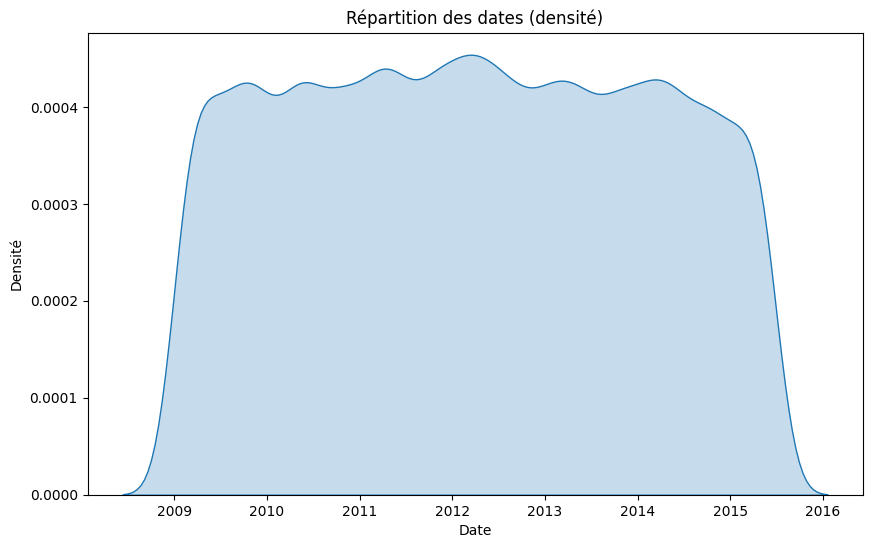

In [283]:
# graphique
plt.figure(figsize=(10, 6))
sb.kdeplot(taxi_test['datedep'], fill=True)
plt.title('Répartition des dates (densité)')
plt.xlabel('Date')
plt.ylabel('Densité')
plt.show()

In [284]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 100000  individus et  9  variables.


In [285]:
#variable Pickup_latitude
#la latitude est comprise entre [-90;90] : on supprime les valeurs en dehors de cette intervalle
cond=(taxi_test['pickup_latitude']<=90) & (taxi_test['pickup_latitude']>-90)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

In [286]:
#suppression des latitudes à 0
cond=(taxi_test['pickup_latitude']>=1) | (taxi_test['pickup_latitude']<=-1)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

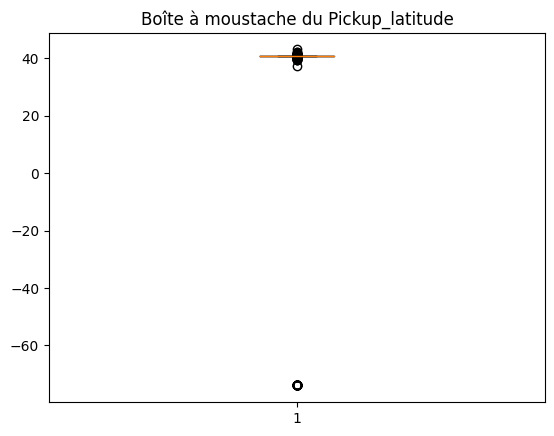

In [287]:
#graphique
plt.boxplot(taxi_test.pickup_latitude)
plt.title("Boîte à moustache du Pickup_latitude")
plt.show()

In [288]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 98099  individus et  9  variables.


In [289]:
#variable Dropoff_latitude
#la latitude est comprise entre [-90;90] : on supprime les valeurs en dehors de cette intervalle
cond=(taxi_test['dropoff_latitude']<=90) & (taxi_test['dropoff_latitude']>-90)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

In [290]:
#suppression des latitudes à 0
cond=(taxi_test['pickup_latitude']>=1) | (taxi_test['pickup_latitude']<=-1)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

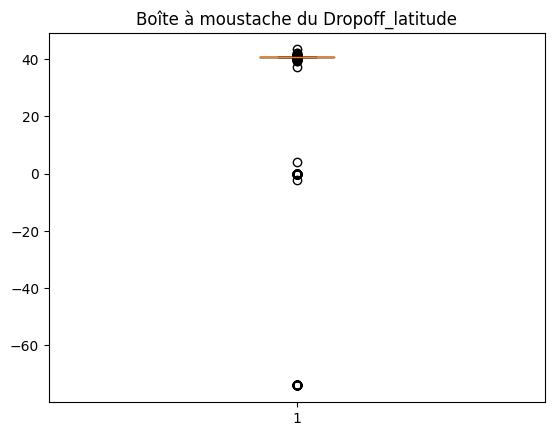

In [291]:
#graphique
plt.boxplot(taxi_test.dropoff_latitude)
plt.title("Boîte à moustache du Dropoff_latitude")
plt.show()

In [292]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 98098  individus et  9  variables.


In [293]:
#variable Pickup_longitude
#la longitude est comprise entre [-180;180] : on supprime les valeurs en dehors de cette intervalle
cond=(taxi_test['pickup_longitude']<=180) & (taxi_test['pickup_longitude']>=-180)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

In [294]:
#suppression des latitudes à 0
cond=(taxi_test['pickup_latitude']>=1) | (taxi_test['pickup_latitude']<=-1)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

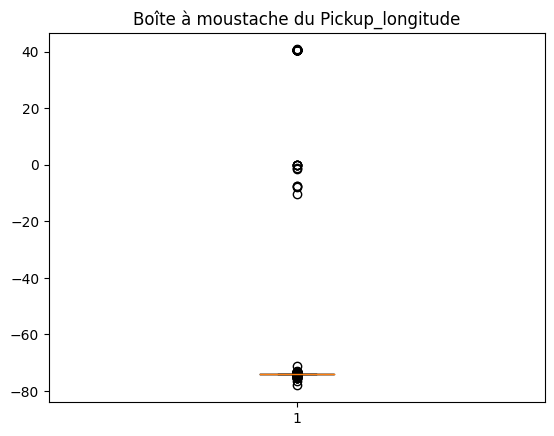

In [295]:
#graphique
plt.boxplot(taxi_test.pickup_longitude)
plt.title("Boîte à moustache du Pickup_longitude")
plt.show()

In [296]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 98098  individus et  9  variables.


In [297]:
#variable Dropoff_longitude
#la longitude est comprise entre [-180;180] : on supprime les valeurs en dehors de cette intervalle
cond=(taxi_test['dropoff_longitude']<=180) & (taxi_test['dropoff_longitude']>=-180)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

In [298]:
#suppression des latitudes à 0
cond=(taxi_test['pickup_latitude']>=1) | (taxi_test['pickup_latitude']<=-1)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

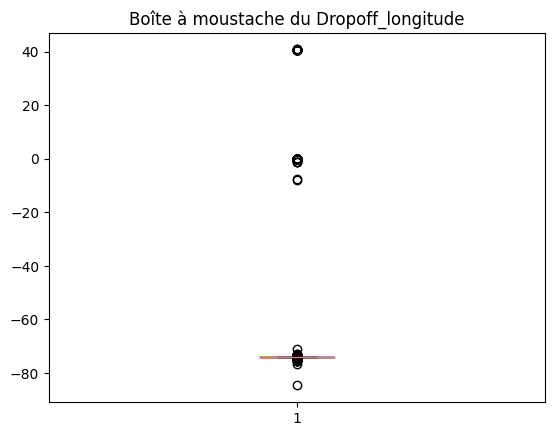

In [299]:
#graphique
plt.boxplot(taxi_test.dropoff_longitude)
plt.title("Boîte à moustache du Dropoff_longitude")
plt.show()

In [300]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 98098  individus et  9  variables.


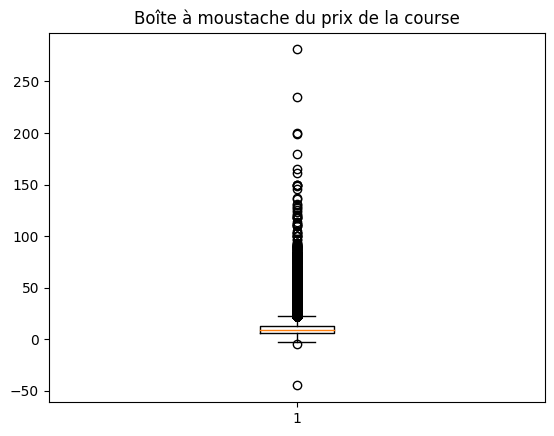

In [301]:
# données aberrantes de la variable fare_amount
plt.boxplot(taxi_test.fare_amount)
plt.title("Boîte à moustache du prix de la course")
plt.show()
#données aberrantes

In [302]:
# on supprime les lignes qui ont un prix de course négatif
taxi_test.drop(taxi_test[taxi_test['fare_amount']<0].index,inplace=True)

In [303]:
# on détermine le prix max d'une course pour 99% des individus
bornesup = taxi_test['fare_amount'].quantile(0.99)

In [304]:
# on supprime les lignes qui ont un prix supérieur à cette borne
taxi_test.drop(taxi_test[taxi_test['fare_amount']>bornesup].index,inplace=True)

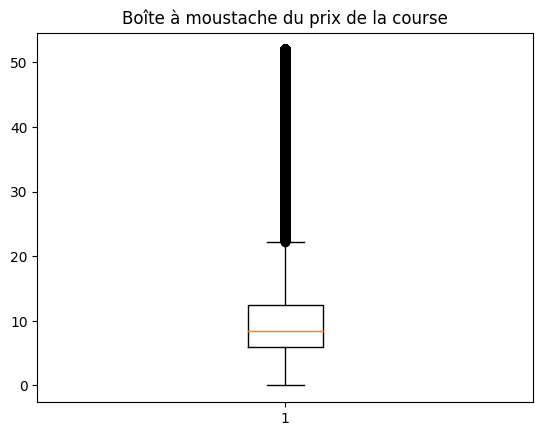

In [305]:
plt.boxplot(taxi_test.fare_amount)
plt.title("Boîte à moustache du prix de la course")
plt.show()

In [306]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 97129  individus et  9  variables.


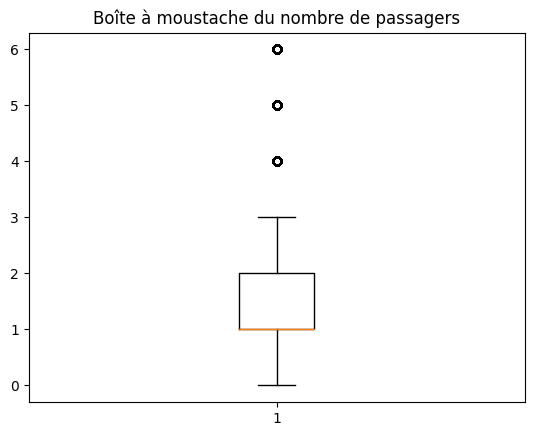

In [307]:
# variable Passenger_count
plt.boxplot(taxi_test.passenger_count)
plt.title("Boîte à moustache du nombre de passagers")
plt.show()
#données aberrantes

In [308]:
#on supprime les lignes où le nombre de passagers est supérieur à 8 (un van a 9 places)
taxi_test.drop(taxi_test[taxi_test['passenger_count']>8].index,inplace=True)

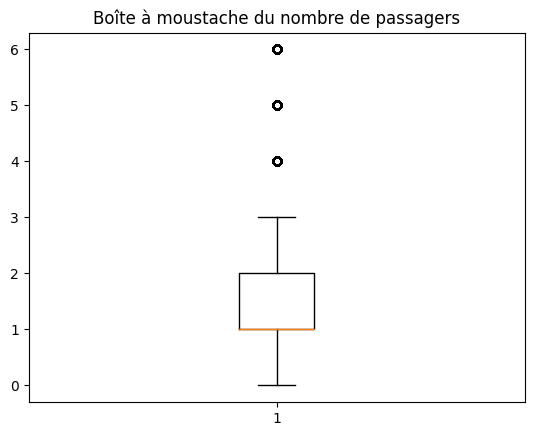

In [309]:
plt.boxplot(taxi_test.passenger_count)
plt.title("Boîte à moustache du nombre de passagers")
plt.show()

In [310]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 97129  individus et  9  variables.


# Feature Engineering

In [311]:
# Calcul de la distance de Manhattan entre les 4 variables de coordonnées

taxi_test['manhattan_distance_km'] = taxi_test.apply(lambda row: geodesic((row['pickup_latitude'], row['pickup_longitude']),
                                                            (row['dropoff_latitude'], row['pickup_longitude'])).kilometers +
                                               geodesic((row['dropoff_latitude'], row['pickup_longitude']),
                                                            (row['dropoff_latitude'], row['dropoff_longitude'])).kilometers, axis=1)

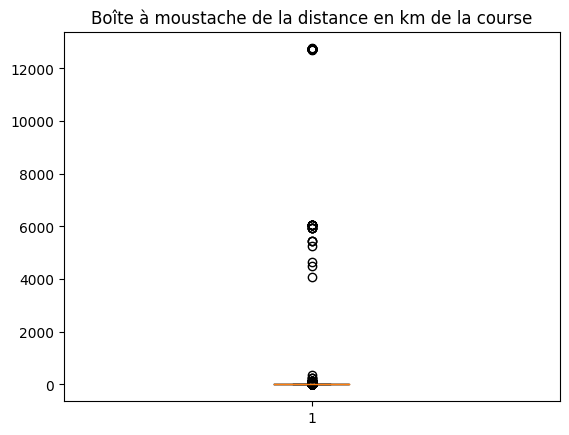

In [312]:
# On regarde si présence de données aberrantes dans la nouvelle variable manhattan_distance_km
plt.boxplot(taxi_test.manhattan_distance_km)
plt.title("Boîte à moustache de la distance en km de la course")
plt.show()
# données aberrantes ? (valeurs trop importantes en km)

In [313]:
# on détermine la distance max d'une course pour 99% des individus
bornesup = taxi_test['manhattan_distance_km'].quantile(0.99)

In [314]:
# on supprime les lignes qui ont un prix supérieur à cette borne
taxi_test.drop(taxi_test[taxi_test['manhattan_distance_km']>bornesup].index,inplace=True)

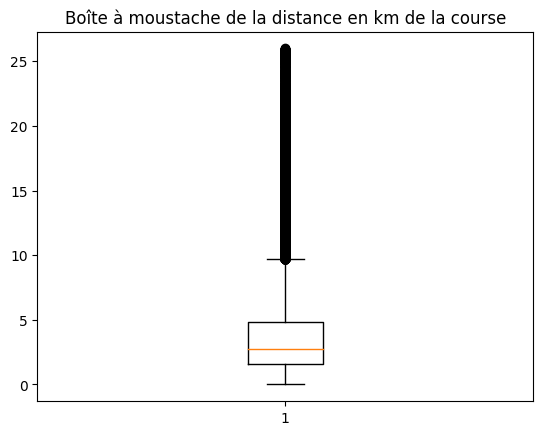

In [315]:
# Vérification
plt.boxplot(taxi_test.manhattan_distance_km)
plt.title("Boîte à moustache de la distance en km de la course")
plt.show()

In [316]:
# Création des classes de distances également réparties de la variable 'manhattan_distance_km'

# Utiliser qcut pour découper en 5 classes

taxi_test['distance_classe_manhattan_kms'], bins = pd.qcut(taxi_test['manhattan_distance_km'], q=5, labels=False, retbins=True)

# Créer des noms de classe basés sur les intervalles

class_names = [f'[{round(bins[i], 2)}; {round(bins[i+1], 2)}[' for i in range(len(bins)-1)]
class_names.append(f'[{round(bins[-1], 2)}; inf[')

# Attribuer les noms de classe à la variable 'distance_classe'

taxi_test['distance_classe_manhattan_kms'] = taxi_test['distance_classe_manhattan_kms'].apply(lambda x: class_names[x])

# Suppression de la variable de distance

taxi_test.drop("manhattan_distance_km", axis=1, inplace=True)

taxi_test.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_ny,datedep,distance_classe_manhattan_kms
105775,2011-11-17 19:10:53.0000003,6.1,-73.973295,40.743817,-73.986726,40.740075,1,2011-11-17 14:10:53-05:00,2011-11-17,[1.39; 2.21[
13154,2010-02-28 08:46:06.0000001,4.1,-73.999379,40.733547,-73.987801,40.728375,1,2010-02-28 03:46:06-05:00,2010-02-28,[1.39; 2.21[
181761,2009-12-24 12:07:35.0000003,9.3,-73.981620,40.778520,-73.954428,40.763992,1,2009-12-24 07:07:35-05:00,2009-12-24,[3.35; 5.63[
191939,2015-01-20 23:15:33.0000002,7.5,-74.004341,40.747765,-73.991211,40.735119,1,2015-01-20 18:15:33-05:00,2015-01-20,[2.21; 3.35[
149011,2009-05-23 17:29:00.000000151,6.9,-73.962005,40.767942,-73.954818,40.788557,1,2009-05-23 13:29:00-04:00,2009-05-23,[2.21; 3.35[


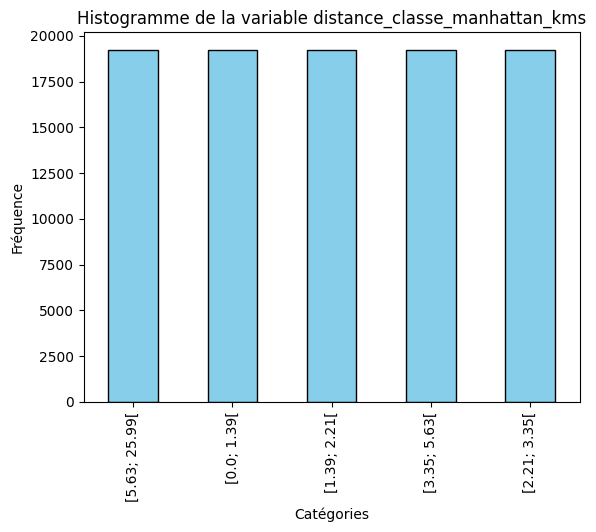

In [317]:
# Vérification de la bonne distribution de la nouvelle variable de classe
taxi_test['distance_classe_manhattan_kms'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Histogramme de la variable distance_classe_manhattan_kms")
plt.xlabel("Catégories")
plt.ylabel("Fréquence")
plt.show()

In [318]:
# Création de la variable 'type_vehicule'

# taxi_test['type_vehicule'] = ['Voiture' if int(count) < 5 else 'Van' for count in taxi_test['passenger_count']]

In [319]:
taxi_test.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_ny,datedep,distance_classe_manhattan_kms
105775,2011-11-17 19:10:53.0000003,6.1,-73.973295,40.743817,-73.986726,40.740075,1,2011-11-17 14:10:53-05:00,2011-11-17,[1.39; 2.21[
13154,2010-02-28 08:46:06.0000001,4.1,-73.999379,40.733547,-73.987801,40.728375,1,2010-02-28 03:46:06-05:00,2010-02-28,[1.39; 2.21[
181761,2009-12-24 12:07:35.0000003,9.3,-73.981620,40.778520,-73.954428,40.763992,1,2009-12-24 07:07:35-05:00,2009-12-24,[3.35; 5.63[
191939,2015-01-20 23:15:33.0000002,7.5,-74.004341,40.747765,-73.991211,40.735119,1,2015-01-20 18:15:33-05:00,2015-01-20,[2.21; 3.35[
149011,2009-05-23 17:29:00.000000151,6.9,-73.962005,40.767942,-73.954818,40.788557,1,2009-05-23 13:29:00-04:00,2009-05-23,[2.21; 3.35[


In [320]:
# Charger le fichier GeoJSON
gdf = gpd.read_file('/content/drive/MyDrive/Projet BIG DATA/newyork-borough.geojson')

In [321]:
#conservation des colonnes utiles
gdf=gdf[['BoroCode', 'BoroName', 'geometry']]

In [322]:
# Créer un GeoDataFrame à partir du DataFrame des quartiers de New York
quartiers_gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

In [323]:
# Créer une fonction pour attribuer le quartier en fonction de la latitude et de la longitude
def trouver_quartier(latitude, longitude, gdf_quartiers):
    point = Point(longitude, latitude)
    for idx, row in gdf_quartiers.iterrows():
        if point.within(row['geometry']):
            return row['BoroName']
    return 'Quartier en dehors de New York'

In [324]:
# Appliquer la fonction pour obtenir le quartier de départ et d'arrivée
taxi_test['quartier_depart'] = taxi_test.apply(lambda row: trouver_quartier(row['pickup_latitude'], row['pickup_longitude'], quartiers_gdf), axis=1)
taxi_test['quartier_arrivee'] = taxi_test.apply(lambda row: trouver_quartier(row['dropoff_latitude'], row['dropoff_longitude'], quartiers_gdf), axis=1)

In [325]:
taxi_test.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_ny,datedep,distance_classe_manhattan_kms,quartier_depart,quartier_arrivee
105775,2011-11-17 19:10:53.0000003,6.1,-73.973295,40.743817,-73.986726,40.740075,1,2011-11-17 14:10:53-05:00,2011-11-17,[1.39; 2.21[,Manhattan,Manhattan
13154,2010-02-28 08:46:06.0000001,4.1,-73.999379,40.733547,-73.987801,40.728375,1,2010-02-28 03:46:06-05:00,2010-02-28,[1.39; 2.21[,Manhattan,Manhattan
181761,2009-12-24 12:07:35.0000003,9.3,-73.981620,40.778520,-73.954428,40.763992,1,2009-12-24 07:07:35-05:00,2009-12-24,[3.35; 5.63[,Manhattan,Manhattan
191939,2015-01-20 23:15:33.0000002,7.5,-74.004341,40.747765,-73.991211,40.735119,1,2015-01-20 18:15:33-05:00,2015-01-20,[2.21; 3.35[,Manhattan,Manhattan
149011,2009-05-23 17:29:00.000000151,6.9,-73.962005,40.767942,-73.954818,40.788557,1,2009-05-23 13:29:00-04:00,2009-05-23,[2.21; 3.35[,Manhattan,Manhattan


In [326]:
# Convertissez 'monuments' en GeoDataFrame
gdf_monuments = gpd.GeoDataFrame(monuments,
                                 geometry=gpd.points_from_xy(monuments['Longitude'], monuments['Latitude']))

# Créez des colonnes dans votre DataFrame d'origine 'taxi_test' pour les distances aux monuments de départ et d'arrivée
taxi_test['geometry_depart'] = taxi_test.apply(lambda row: Point(row['pickup_latitude'], row['pickup_longitude']), axis=1)
taxi_test['geometry_arrivee'] = taxi_test.apply(lambda row: Point(row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

# Créez une fonction pour calculer la distance
def calculate_distance(point, geometry_series):
    return min(geodesic(point.coords[0], geometry.coords[0]).meters for geometry in geometry_series)

# Appliquez la fonction pour les lieux de départ et d'arrivée
taxi_test['distance_depart_monument'] = taxi_test['geometry_depart'].apply(lambda point: calculate_distance(point, gdf_monuments['geometry']))
taxi_test['distance_arrivee_monument'] = taxi_test['geometry_arrivee'].apply(lambda point: calculate_distance(point, gdf_monuments['geometry']))

# Ajoutez une colonne binaire indiquant si la distance est inférieure à 500 mètres
taxi_test['proximite_depart_monument'] = taxi_test['distance_depart_monument'] < 500
taxi_test['proximite_arrivee_monument'] = taxi_test['distance_arrivee_monument'] < 500

# Supprimez les colonnes de géométrie
taxi_test = taxi_test.drop(['geometry_depart', 'geometry_arrivee'], axis=1)

# Convertir les valeurs True/False en 1/0
taxi_test['proximite_depart_monument'] = taxi_test['proximite_depart_monument'].astype(int)
taxi_test['proximite_arrivee_monument'] = taxi_test['proximite_arrivee_monument'].astype(int)

# Supprimer les colonnes de distances
taxi_test = taxi_test.drop(['distance_depart_monument', 'distance_arrivee_monument'], axis=1)

In [327]:
taxi_test.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_ny,datedep,distance_classe_manhattan_kms,quartier_depart,quartier_arrivee,proximite_depart_monument,proximite_arrivee_monument
105775,2011-11-17 19:10:53.0000003,6.1,-73.973295,40.743817,-73.986726,40.740075,1,2011-11-17 14:10:53-05:00,2011-11-17,[1.39; 2.21[,Manhattan,Manhattan,0,0
13154,2010-02-28 08:46:06.0000001,4.1,-73.999379,40.733547,-73.987801,40.728375,1,2010-02-28 03:46:06-05:00,2010-02-28,[1.39; 2.21[,Manhattan,Manhattan,0,0
181761,2009-12-24 12:07:35.0000003,9.3,-73.981620,40.778520,-73.954428,40.763992,1,2009-12-24 07:07:35-05:00,2009-12-24,[3.35; 5.63[,Manhattan,Manhattan,0,0
191939,2015-01-20 23:15:33.0000002,7.5,-74.004341,40.747765,-73.991211,40.735119,1,2015-01-20 18:15:33-05:00,2015-01-20,[2.21; 3.35[,Manhattan,Manhattan,0,0
149011,2009-05-23 17:29:00.000000151,6.9,-73.962005,40.767942,-73.954818,40.788557,1,2009-05-23 13:29:00-04:00,2009-05-23,[2.21; 3.35[,Manhattan,Manhattan,0,0


In [328]:
def moment_journee(heure):
    """
    Fonction permettant de récupérer le moment de la journée en fonction d'une heure passée en paramètre
    Parameters
    ----------
    heure : int (heure de la journée dont ou souhaite récupérer le moment)
    """
    if heure>=5 and heure<12 :
        return("Matin")
    elif heure>=12 and heure<14 :
        return('Midi')
    elif heure>=14 and heure<18 :
        return("Après-midi")
    elif heure>=18 and heure<21 :
        return('Soir')
    else :
        return('Nuit')

In [329]:
def moment_semaine(jour):
    """
    Fonction qui permet de récupérer le moment de la semaine pour un jour passée en paramètre
    Parameters
    ----------
    jour : int (numéro du jour dont on souhaite récupérer le moment de la semaine (semaine ou week-end) : 0 pour lundi, 1 pour mardi...)
    """
    if jour<=4 :
        return("Semaine")#Semaine
    else :
        return('Week-end')#Week-End

In [330]:
def saison(mois):
    """
    Fonction qui permet de récupérer le moment de la semaine pour un jour passée en paramètre
    Parameters
    ----------
    mois : int (numéro du mois dont on souhaite récupérer la saison)
    """
    if mois>=3 and mois<6 :
        return("Printemps")
    elif mois>=6 and mois<9 :
        return('Été')
    elif mois>=9 and mois<12 :
        return("Automne")
    else :
        return('Hiver')

In [331]:
def is_holiday(date):
    """
    Fonction qui permet de récupérer si oui ou non le jour passé en paramètre est férié dans l'état de New-York
    Parameters
    ----------
    date : datetime (date de laquelle on souhaite savoir si férié ou non)
    """
    return date in holidays.UnitedStates(years=date.year, state='NY')

In [332]:
#Mise au format datetime de la variable pickup_datetime_ny
taxi_test['pickup_datetime_ny'] = pd.to_datetime(taxi_test['pickup_datetime_ny'])

#Jour de la semaine de début de trajet
taxi_test['pickup_day'] = taxi_test['pickup_datetime_ny'].dt.day_name()

#Mois de début de trajet
taxi_test['pickup_month'] = taxi_test['pickup_datetime_ny'].dt.month_name()

#Trimestre de début de trajet
taxi_test['pickup_quarter'] = taxi_test['pickup_datetime_ny'].dt.quarter

#Année de début de trajet
taxi_test['pickup_year'] = taxi_test['pickup_datetime_ny'].dt.year

#Saison de début de trajet
taxi_test['pickup_season'] = taxi_test['pickup_datetime_ny'].dt.month.map(saison)

#Moment de la journée
taxi_test['pickup_daytime'] = taxi_test['pickup_datetime_ny'].dt.hour.map(moment_journee)

#Moment de la semaine
taxi_test['pickup_weektime'] = taxi_test['pickup_datetime_ny'].dt.weekday.map(moment_semaine)

#Jour férié
taxi_test['holidays'] = taxi_test['pickup_datetime_ny'].dt.date.apply(is_holiday)

In [333]:
# Créez une variable d'heure de pointe
taxi_test['peak_hour'] = taxi_test['pickup_datetime_ny'].apply(
    lambda x: 1 if (x.hour >= 7 and x.hour < 10) or (x.hour >= 16 and x.hour < 19) else 0
)

Nous allons réaliser la jointure sur la date entre notre df 'taxi_test' et le df 'fuel_price'

In [334]:
# Convertissez la colonne 'datedep' en type datetime64[ns] et utilisez le fuseau horaire UTC
taxi_test['datedep'] = pd.to_datetime(taxi_test['datedep']).dt.tz_localize(None)

# Convertissez la colonne 'Date' en type datetime64[ns] et utilisez le fuseau horaire UTC
fuel_price['Date_Extended'] = pd.to_datetime(fuel_price['Date_Extended']).dt.tz_localize(None)

# Fusionnez les DataFrames sur la colonne de date
taxi_test = pd.merge(taxi_test, fuel_price, left_on='datedep', right_on='Date_Extended', how='left')

# Remplissez les valeurs manquantes en avant pour étendre la valeur du lundi à tous les jours de la semaine
taxi_test['New York City Average ($/gal)'] = taxi_test['New York City Average ($/gal)'].fillna(method='ffill')

In [335]:
# Comptez le nombre de NaN dans la colonne 'New York City Average ($/gal)'
nan_count = taxi_test['New York City Average ($/gal)'].isna().sum()

# Affichez le résultat
print(f"Nombre de NaN dans la colonne 'New York City Average ($/gal)': {nan_count}")

Nombre de NaN dans la colonne 'New York City Average ($/gal)': 0


In [403]:
# Pour les valeurs nulles, nous allons les remplacer par la moyenne de la variable

# Calculer la moyenne de la variable 'New York City Average ($/gal)'
mean_fuel_price = taxi_test['New York City Average ($/gal)'].mean()

# Remplacer les valeurs nulles par la moyenne calculée
taxi_test['New York City Average ($/gal)'].fillna(mean_fuel_price, inplace=True)

In [337]:
# Supprimer les lignes où à la fois quartier_depart et quartier_arrivee ont la valeur 'Quartier en dehors de New York'
taxi_test = taxi_test[(taxi_test['quartier_depart'] != 'Quartier en dehors de New York') &
                      (taxi_test['quartier_arrivee'] != 'Quartier en dehors de New York')]

# Données finales

In [341]:
# Suppression des variables

#taxi_test.drop("passenger_count", axis=1, inplace=True)
#taxi_test.drop("key", axis=1, inplace=True)
taxi_test.drop("pickup_datetime_ny", axis=1, inplace=True)
taxi_test.drop("pickup_year", axis=1, inplace=True)
taxi_test.drop("pickup_longitude", axis=1, inplace=True)
taxi_test.drop("pickup_latitude", axis=1, inplace=True)
taxi_test.drop("dropoff_longitude", axis=1, inplace=True)
taxi_test.drop("dropoff_latitude", axis=1, inplace=True)
#taxi_test.drop("datedep", axis=1, inplace=True)
taxi_test.drop("Date_Extended", axis=1, inplace=True)

KeyError: "['pickup_datetime_ny'] not found in axis"

In [404]:
taxi_test.head(50)

,fare_amount,passenger_count,distance_classe_manhattan_kms,quartier_depart,quartier_arrivee,proximite_depart_monument,proximite_arrivee_monument,pickup_day,pickup_month,pickup_quarter,pickup_season,pickup_daytime,pickup_weektime,holidays,peak_hour,Date_Extended,New York City Average ($/gal)
0,6.1,1,[1.39; 2.21[,Manhattan,Manhattan,0,0,Thursday,November,4,Automne,Après-midi,Semaine,False,0,2011-11-17,3.76
1,4.1,1,[1.39; 2.21[,Manhattan,Manhattan,0,0,Sunday,February,1,Hiver,Nuit,Week-end,False,0,2010-02-28,2.90
2,9.3,1,[3.35; 5.63[,Manhattan,Manhattan,0,0,Thursday,December,4,Hiver,Matin,Semaine,False,1,2009-12-24,2.87
3,7.5,1,[2.21; 3.35[,Manhattan,Manhattan,0,0,Tuesday,January,1,Hiver,Soir,Semaine,False,1,2015-01-20,2.50
4,6.9,1,[2.21; 3.35[,Manhattan,Manhattan,0,0,Saturday,May,2,Printemps,Midi,Week-end,False,0,2009-05-23,2.56
5,8.5,5,[3.35; 5.63[,Manhattan,Manhattan,0,0,Wednesday,September,3,Automne,Après-midi,Semaine,False,0,2010-09-22,2.88
6,12.5,2,[5.63; 25.99[,Manhattan,Manhattan,0,0,Wednesday,March,1,Printemps,Nuit,Semaine,False,0,2013-03-13,4.04
7,4.1,1,[0.0; 1.39[,Manhattan,Manhattan,0,0,Sunday,May,2,Printemps,Matin,Week-end,False,0,2012-05-27,4.01
8,7.3,1,[2.21; 3.35[,Manhattan,Manhattan,0,0,Tuesday,May,2,Printemps,Soir,Semaine,False,1,2012-05-01,4.17
9,3.5,1,[0.0; 1.39[,Manhattan,Manhattan,0,0,Sunday,January,1,Hiver,Matin,Week-end,False,0,2014-01-26,3.69


In [345]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 95844  individus et  17  variables.


# Export des données

In [346]:
from google.colab import drive

# Remontez votre Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [347]:
# Exportez le DataFrame au format CSV vers votre Google Drive
taxi_test.to_csv('/content/drive/MyDrive/Projet BIG DATA/fichier_resultat_V4.csv', index=False)

# Statistiques bivariées

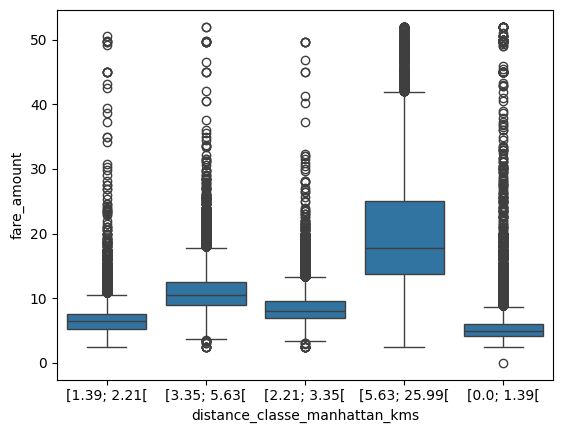

In [351]:
# fare_amount*distance_classe_manhattan_kms
sb.boxplot(x='distance_classe_manhattan_kms', y='fare_amount', data=taxi_test)
plt.show()

In [352]:
# fare_amount*type_vehicule
#sb.boxplot(x='type_vehicule', y='fare_amount', data=taxi_test)
#plt.show()

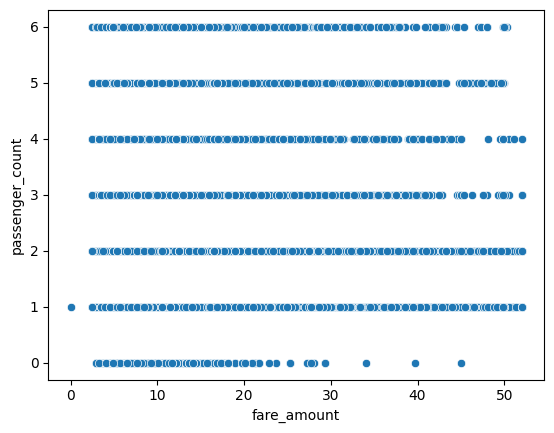

In [353]:
# Créer un nuage de points
sb.scatterplot(x='fare_amount', y='passenger_count', data=taxi_test)
plt.show()

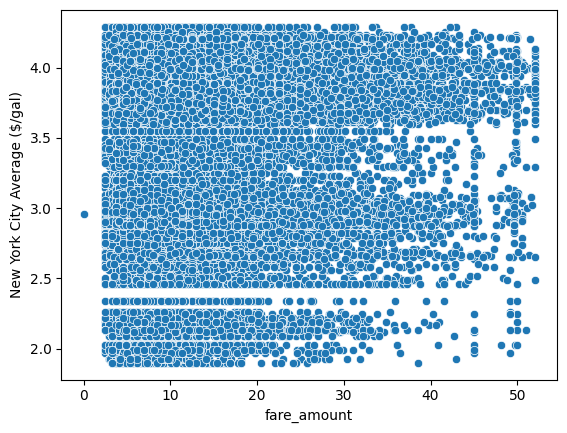

In [354]:
# Créer un nuage de points
sb.scatterplot(x='fare_amount', y='New York City Average ($/gal)', data=taxi_test)
plt.show()

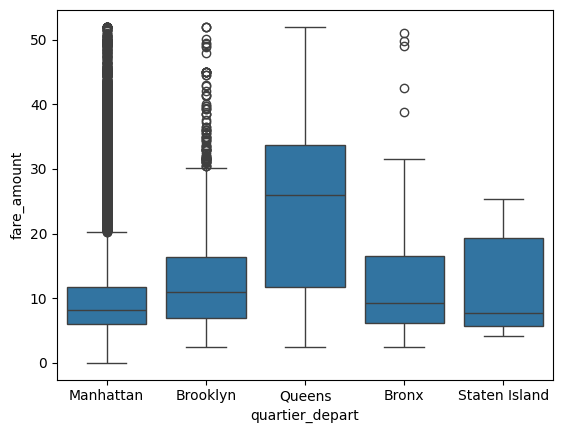

In [355]:
# fare_amount*quartier_depart
sb.boxplot(x='quartier_depart', y='fare_amount', data=taxi_test)
plt.show()

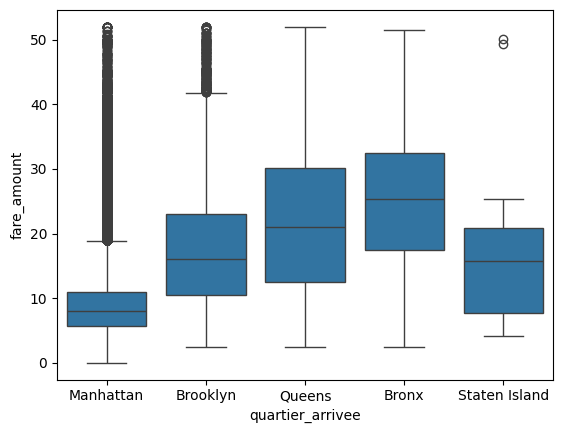

In [356]:
# fare_amount*quartier_arrivee
sb.boxplot(x='quartier_arrivee', y='fare_amount', data=taxi_test)
plt.show()

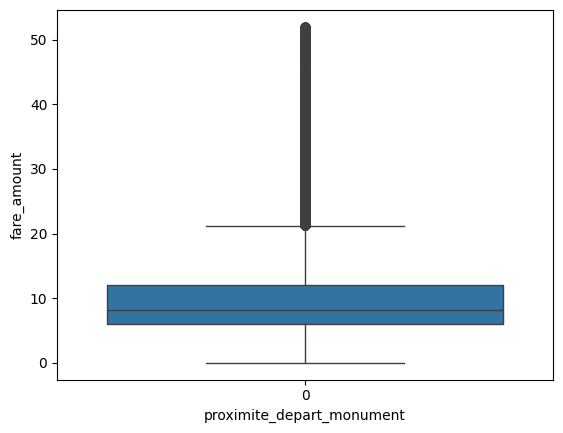

In [357]:
# fare_amount*proximite_depart_monument
sb.boxplot(x='proximite_depart_monument', y='fare_amount', data=taxi_test)
plt.show()

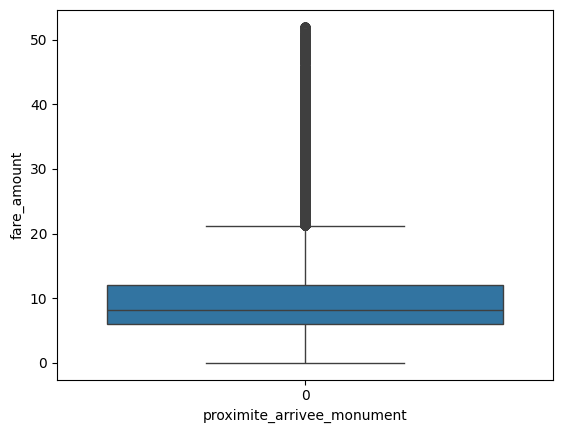

In [358]:
# fare_amount*proximite_arrivee_monument
sb.boxplot(x='proximite_arrivee_monument', y='fare_amount', data=taxi_test)
plt.show()

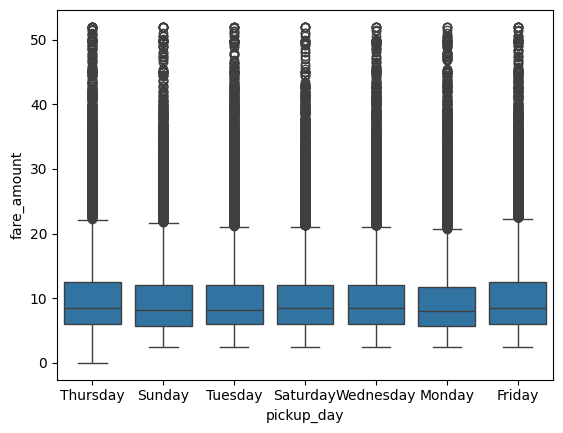

In [359]:
# fare_amount*pickup_day
sb.boxplot(x='pickup_day', y='fare_amount', data=taxi_test)
plt.show()

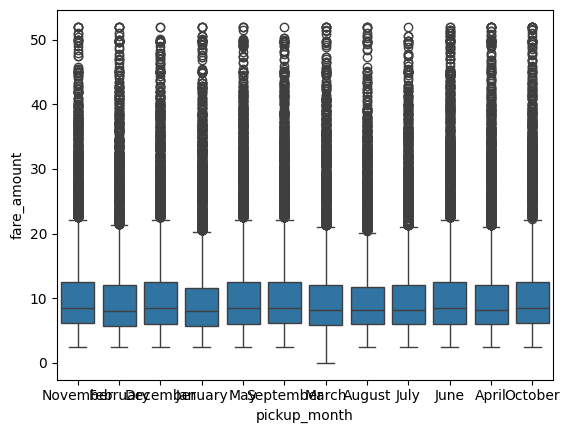

In [360]:
# fare_amount*pickup_month
sb.boxplot(x='pickup_month', y='fare_amount', data=taxi_test)
plt.show()

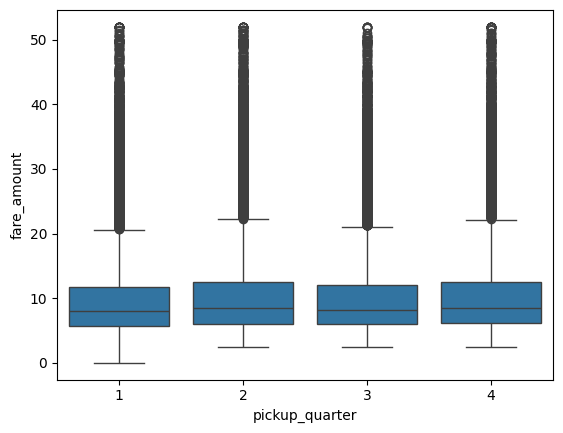

In [361]:
# fare_amount*pickup_quarter
sb.boxplot(x='pickup_quarter', y='fare_amount', data=taxi_test)
plt.show()

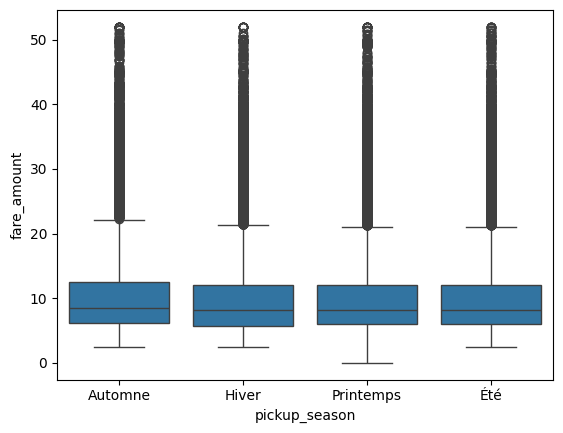

In [362]:
# fare_amount*pickup_season
sb.boxplot(x='pickup_season', y='fare_amount', data=taxi_test)
plt.show()

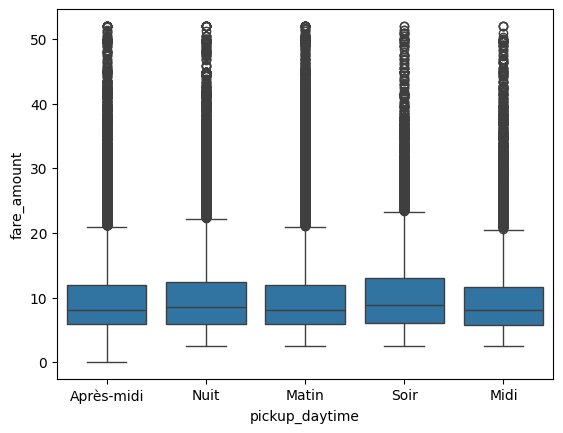

In [363]:
# fare_amount*pickup_daytime
sb.boxplot(x='pickup_daytime', y='fare_amount', data=taxi_test)
plt.show()

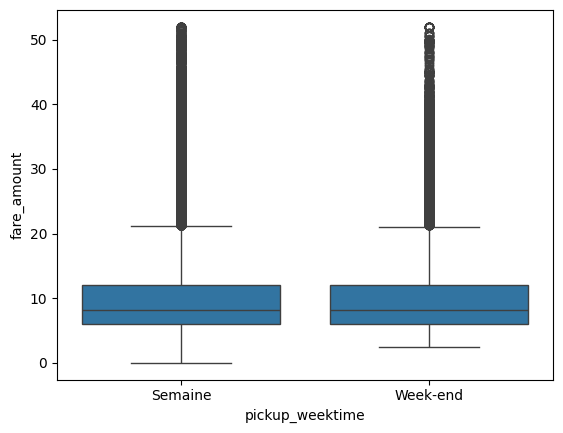

In [364]:
# fare_amount*pickup_weektime
sb.boxplot(x='pickup_weektime', y='fare_amount', data=taxi_test)
plt.show()

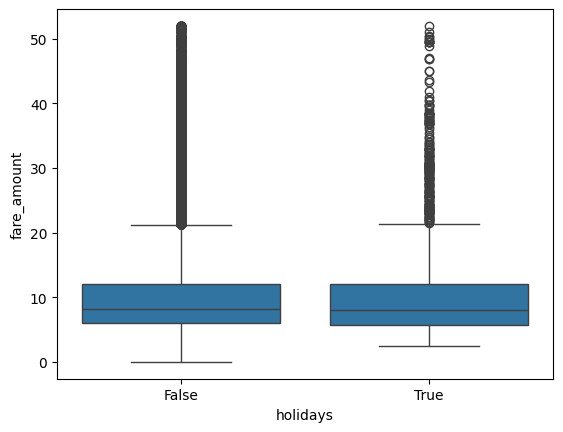

In [365]:
# fare_amount*holidays
sb.boxplot(x='holidays', y='fare_amount', data=taxi_test)
plt.show()

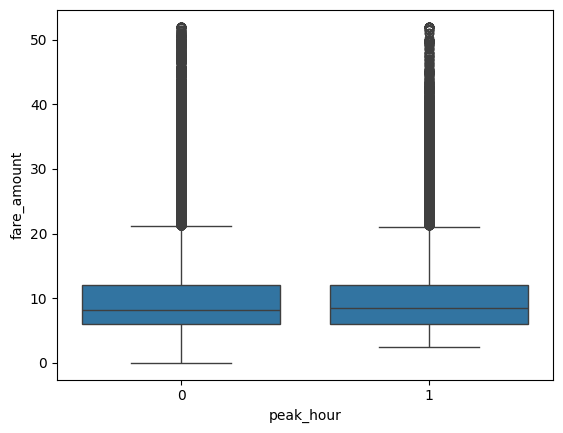

In [366]:
# fare_amount*peak_hour
sb.boxplot(x='peak_hour', y='fare_amount', data=taxi_test)
plt.show()

In [367]:
def summary_stats_grouped(taxi_test, quantitative_var, qualitative_var):
    # Calculer la moyenne groupée par la variable qualitative
    mean_by_group = taxi_test.groupby(qualitative_var)[quantitative_var].mean()

    # Calculer la médiane groupée par la variable qualitative
    median_by_group = taxi_test.groupby(qualitative_var)[quantitative_var].median()

    # Calculer les quartiles groupés par la variable qualitative
    quartiles_by_group = taxi_test.groupby(qualitative_var)[quantitative_var].quantile([0.25, 0.5, 0.75])

    # Calculer le minimum groupé par la variable qualitative
    min_by_group = taxi_test.groupby(qualitative_var)[quantitative_var].min()

    # Calculer le maximum groupé par la variable qualitative
    max_by_group = taxi_test.groupby(qualitative_var)[quantitative_var].max()

    # Retourner les résultats
    return mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group

mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'distance_classe_manhattan_kms')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
distance_classe_manhattan_kms
[0.0; 1.39[       5.693714
[1.39; 2.21[      6.763702
[2.21; 3.35[      8.443414
[3.35; 5.63[     10.998953
[5.63; 25.99[    20.229404
Name: fare_amount, dtype: float64

Médiane par groupe:
distance_classe_manhattan_kms
[0.0; 1.39[       4.9
[1.39; 2.21[      6.5
[2.21; 3.35[      8.0
[3.35; 5.63[     10.5
[5.63; 25.99[    17.7
Name: fare_amount, dtype: float64

Quartiles par groupe:
distance_classe_manhattan_kms      
[0.0; 1.39[                    0.25     4.1
                               0.50     4.9
                               0.75     6.0
[1.39; 2.21[                   0.25     5.3
                               0.50     6.5
                               0.75     7.5
[2.21; 3.35[                   0.25     6.9
                               0.50     8.0
                               0.75     9.5
[3.35; 5.63[                   0.25     8.9
                               0.50    10.5
                               0.75    12.5

In [368]:
#mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'type_vehicule')

#print("Moyenne par groupe:")
#print(mean_by_group)

#print("\nMédiane par groupe:")
#print(median_by_group)

#print("\nQuartiles par groupe:")
#print(quartiles_by_group)

#print("\nMinimum par groupe:")
#print(min_by_group)

#print("\nMaximum par groupe:")
#print(max_by_group)

In [369]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'quartier_depart')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
quartier_depart
Bronx            13.283103
Brooklyn         12.839581
Manhattan         9.788546
Queens           24.048311
Staten Island    11.533333
Name: fare_amount, dtype: float64

Médiane par groupe:
quartier_depart
Bronx             9.3
Brooklyn         10.9
Manhattan         8.1
Queens           26.0
Staten Island     7.7
Name: fare_amount, dtype: float64

Quartiles par groupe:
quartier_depart      
Bronx            0.25     6.1
                 0.50     9.3
                 0.75    16.5
Brooklyn         0.25     7.0
                 0.50    10.9
                 0.75    16.4
Manhattan        0.25     6.0
                 0.50     8.1
                 0.75    11.7
Queens           0.25    11.7
                 0.50    26.0
                 0.75    33.7
Staten Island    0.25     5.7
                 0.50     7.7
                 0.75    19.3
Name: fare_amount, dtype: float64

Minimum par groupe:
quartier_depart
Bronx            2.5
Brooklyn         2.5
Manhat

In [370]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'quartier_arrivee')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
quartier_arrivee
Bronx            24.760304
Brooklyn         17.968081
Manhattan         9.368268
Queens           21.634151
Staten Island    18.793077
Name: fare_amount, dtype: float64

Médiane par groupe:
quartier_arrivee
Bronx            25.3
Brooklyn         16.0
Manhattan         8.0
Queens           21.0
Staten Island    15.7
Name: fare_amount, dtype: float64

Quartiles par groupe:
quartier_arrivee      
Bronx             0.25    17.5
                  0.50    25.3
                  0.75    32.5
Brooklyn          0.25    10.5
                  0.50    16.0
                  0.75    23.0
Manhattan         0.25     5.7
                  0.50     8.0
                  0.75    11.0
Queens            0.25    12.5
                  0.50    21.0
                  0.75    30.1
Staten Island     0.25     7.7
                  0.50    15.7
                  0.75    20.9
Name: fare_amount, dtype: float64

Minimum par groupe:
quartier_arrivee
Bronx            2.5
Brooklyn

In [371]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'proximite_depart_monument')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
proximite_depart_monument
0    10.424967
Name: fare_amount, dtype: float64

Médiane par groupe:
proximite_depart_monument
0    8.1
Name: fare_amount, dtype: float64

Quartiles par groupe:
proximite_depart_monument      
0                          0.25     6.0
                           0.50     8.1
                           0.75    12.1
Name: fare_amount, dtype: float64

Minimum par groupe:
proximite_depart_monument
0    0.0
Name: fare_amount, dtype: float64

Maximum par groupe:
proximite_depart_monument
0    52.0
Name: fare_amount, dtype: float64


In [372]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'proximite_arrivee_monument')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
proximite_arrivee_monument
0    10.424967
Name: fare_amount, dtype: float64

Médiane par groupe:
proximite_arrivee_monument
0    8.1
Name: fare_amount, dtype: float64

Quartiles par groupe:
proximite_arrivee_monument      
0                           0.25     6.0
                            0.50     8.1
                            0.75    12.1
Name: fare_amount, dtype: float64

Minimum par groupe:
proximite_arrivee_monument
0    0.0
Name: fare_amount, dtype: float64

Maximum par groupe:
proximite_arrivee_monument
0    52.0
Name: fare_amount, dtype: float64


In [373]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_day')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_day
Friday       10.529139
Monday       10.235170
Saturday     10.239987
Sunday       10.493389
Thursday     10.639194
Tuesday      10.415306
Wednesday    10.399503
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_day
Friday       8.5
Monday       8.0
Saturday     8.5
Sunday       8.1
Thursday     8.5
Tuesday      8.1
Wednesday    8.5
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_day      
Friday      0.25     6.0
            0.50     8.5
            0.75    12.5
Monday      0.25     5.7
            0.50     8.0
            0.75    11.7
Saturday    0.25     6.0
            0.50     8.5
            0.75    12.1
Sunday      0.25     5.7
            0.50     8.1
            0.75    12.1
Thursday    0.25     6.0
            0.50     8.5
            0.75    12.5
Tuesday     0.25     6.0
            0.50     8.1
            0.75    12.0
Wednesday   0.25     6.0
            0.50     8.5
            0.75    12.1
Name: fare_amount, dtype

In [374]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_month')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_month
April        10.407412
August       10.097876
December     10.656841
February     10.109001
January      10.049117
July         10.137796
June         10.647786
March        10.260660
May          10.565217
November     10.577996
October      10.782744
September    10.833733
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_month
April        8.1
August       8.1
December     8.5
February     8.0
January      8.0
July         8.1
June         8.5
March        8.1
May          8.5
November     8.5
October      8.5
September    8.5
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_month      
April         0.25     6.0
              0.50     8.1
              0.75    12.1
August        0.25     6.0
              0.50     8.1
              0.75    11.7
December      0.25     6.0
              0.50     8.5
              0.75    12.5
February      0.25     5.7
              0.50     8.0
              0.75    12.0
January       0.25 

In [375]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_quarter')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_quarter
1    10.141502
2    10.539920
3    10.361588
4    10.674441
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_quarter
1    8.0
2    8.5
3    8.1
4    8.5
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_quarter      
1               0.25     5.7
                0.50     8.0
                0.75    11.7
2               0.25     6.0
                0.50     8.5
                0.75    12.5
3               0.25     6.0
                0.50     8.1
                0.75    12.1
4               0.25     6.1
                0.50     8.5
                0.75    12.5
Name: fare_amount, dtype: float64

Minimum par groupe:
pickup_quarter
1    0.0
2    2.5
3    2.5
4    2.5
Name: fare_amount, dtype: float64

Maximum par groupe:
pickup_quarter
1    52.0
2    52.0
3    52.0
4    52.0
Name: fare_amount, dtype: float64


In [376]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_season')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_season
Automne      10.732570
Hiver        10.256970
Printemps    10.410931
Été          10.318928
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_season
Automne      8.5
Hiver        8.1
Printemps    8.1
Été          8.1
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_season      
Automne        0.25     6.1
               0.50     8.5
               0.75    12.5
Hiver          0.25     5.7
               0.50     8.1
               0.75    12.0
Printemps      0.25     6.0
               0.50     8.1
               0.75    12.1
Été            0.25     6.0
               0.50     8.1
               0.75    12.1
Name: fare_amount, dtype: float64

Minimum par groupe:
pickup_season
Automne      2.5
Hiver        2.5
Printemps    0.0
Été          2.5
Name: fare_amount, dtype: float64

Maximum par groupe:
pickup_season
Automne      52.0
Hiver        52.0
Printemps    52.0
Été          52.0
Name: fare_amount, dtype: float64


In [377]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_daytime')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_daytime
Après-midi    10.219347
Matin         10.331708
Midi          10.239712
Nuit          10.610079
Soir          10.881744
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_daytime
Après-midi    8.1
Matin         8.1
Midi          8.1
Nuit          8.5
Soir          8.9
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_daytime      
Après-midi      0.25     6.0
                0.50     8.1
                0.75    12.0
Matin           0.25     6.0
                0.50     8.1
                0.75    12.0
Midi            0.25     5.7
                0.50     8.1
                0.75    11.7
Nuit            0.25     6.0
                0.50     8.5
                0.75    12.5
Soir            0.25     6.1
                0.50     8.9
                0.75    13.0
Name: fare_amount, dtype: float64

Minimum par groupe:
pickup_daytime
Après-midi    0.0
Matin         2.5
Midi          2.5
Nuit          2.5
Soir          2.5
Name: fare_a

In [378]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_weektime')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_weektime
Semaine     10.453549
Week-end    10.344336
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_weektime
Semaine     8.1
Week-end    8.1
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_weektime      
Semaine          0.25     6.0
                 0.50     8.1
                 0.75    12.1
Week-end         0.25     6.0
                 0.50     8.1
                 0.75    12.1
Name: fare_amount, dtype: float64

Minimum par groupe:
pickup_weektime
Semaine     0.0
Week-end    2.5
Name: fare_amount, dtype: float64

Maximum par groupe:
pickup_weektime
Semaine     52.0
Week-end    52.0
Name: fare_amount, dtype: float64


In [379]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'holidays')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
holidays
False    10.428831
True     10.298987
Name: fare_amount, dtype: float64

Médiane par groupe:
holidays
False    8.2
True     8.0
Name: fare_amount, dtype: float64

Quartiles par groupe:
holidays      
False     0.25     6.0
          0.50     8.2
          0.75    12.1
True      0.25     5.7
          0.50     8.0
          0.75    12.0
Name: fare_amount, dtype: float64

Minimum par groupe:
holidays
False    0.0
True     2.5
Name: fare_amount, dtype: float64

Maximum par groupe:
holidays
False    52.0
True     52.0
Name: fare_amount, dtype: float64


In [380]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'peak_hour')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
peak_hour
0    10.449711
1    10.371304
Name: fare_amount, dtype: float64

Médiane par groupe:
peak_hour
0    8.1
1    8.5
Name: fare_amount, dtype: float64

Quartiles par groupe:
peak_hour      
0          0.25     6.0
           0.50     8.1
           0.75    12.1
1          0.25     6.0
           0.50     8.5
           0.75    12.1
Name: fare_amount, dtype: float64

Minimum par groupe:
peak_hour
0    0.0
1    2.5
Name: fare_amount, dtype: float64

Maximum par groupe:
peak_hour
0    52.0
1    52.0
Name: fare_amount, dtype: float64


# Statistiques univariées

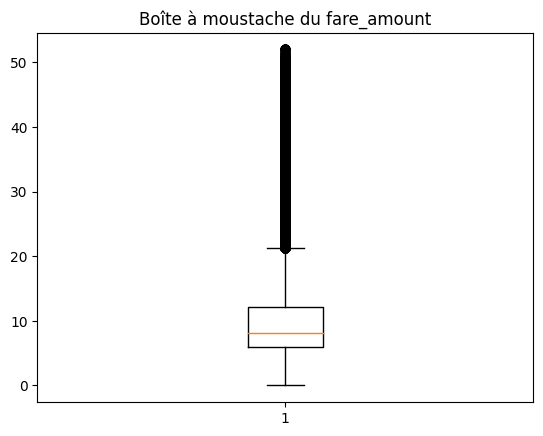

In [381]:
plt.boxplot(taxi_test.fare_amount)
plt.title("Boîte à moustache du fare_amount")
plt.show()

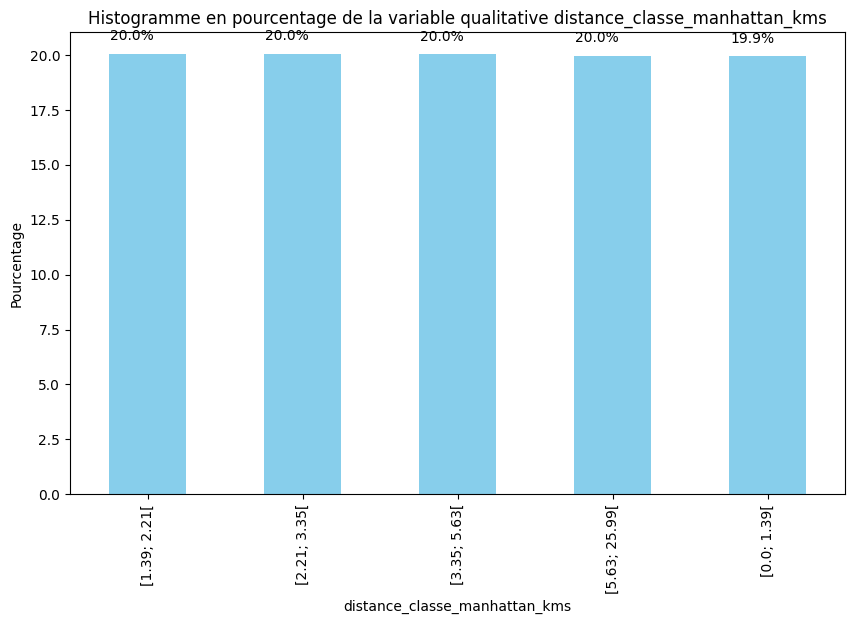

In [382]:
variable_quali = 'distance_classe_manhattan_kms'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

In [383]:
#variable_quali = 'type_vehicule'

# Calculer les pourcentages
#percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
#plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
#bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
#plt.xlabel(variable_quali)
#plt.ylabel('Pourcentage')
#plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
#for bar, percentage in zip(bars.patches, percentages):
#    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
#plt.show()

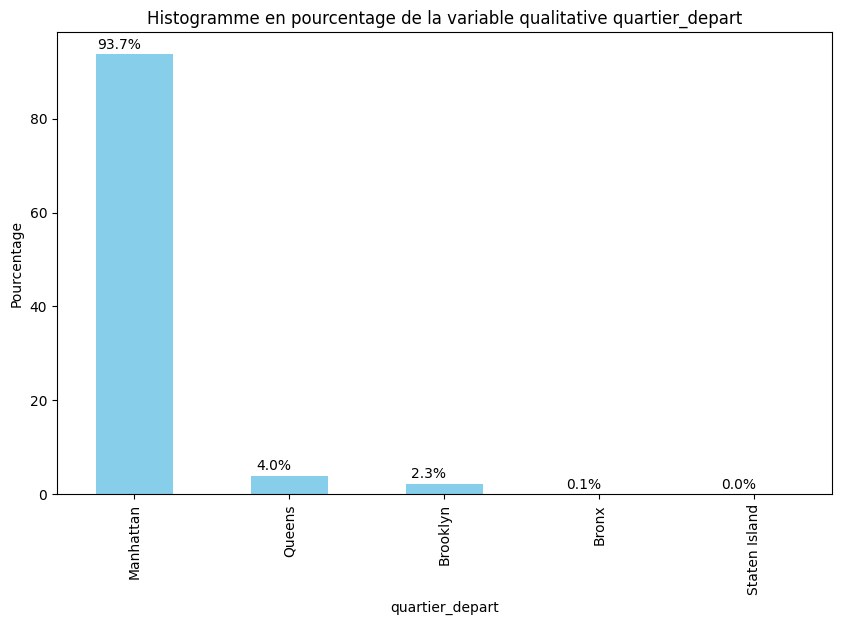

In [384]:
variable_quali = 'quartier_depart'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

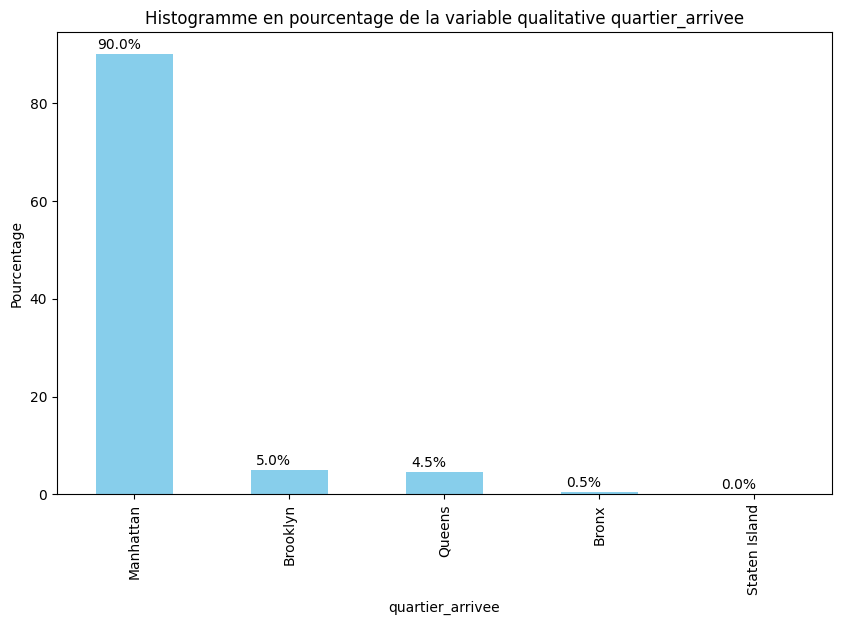

In [385]:
variable_quali = 'quartier_arrivee'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

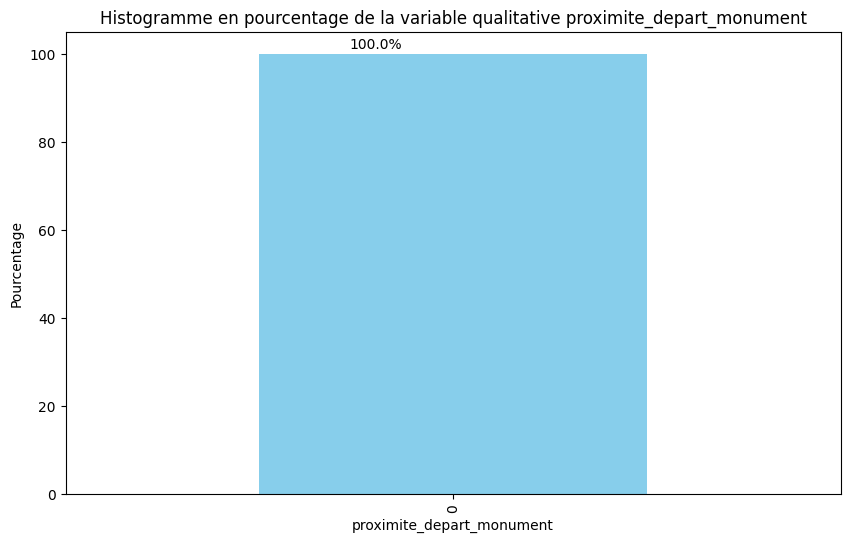

In [386]:
variable_quali = 'proximite_depart_monument'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

On n'est pas à 0 % mais presque

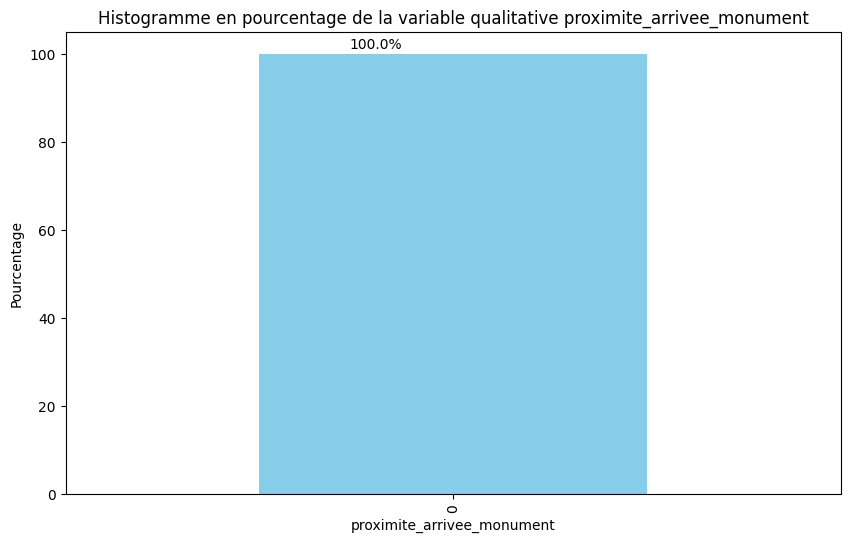

In [387]:
variable_quali = 'proximite_arrivee_monument'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

On n'est pas à 0 % mais presque

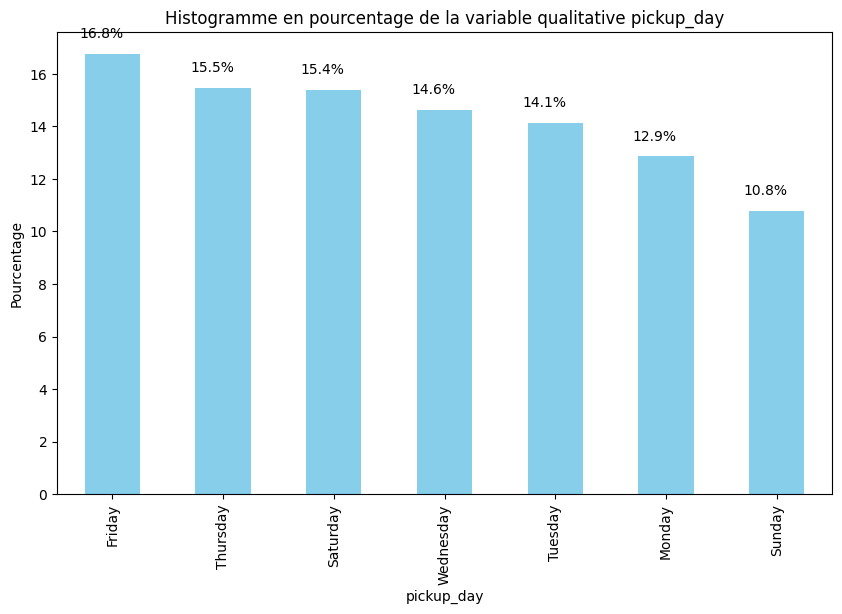

In [388]:
variable_quali = 'pickup_day'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

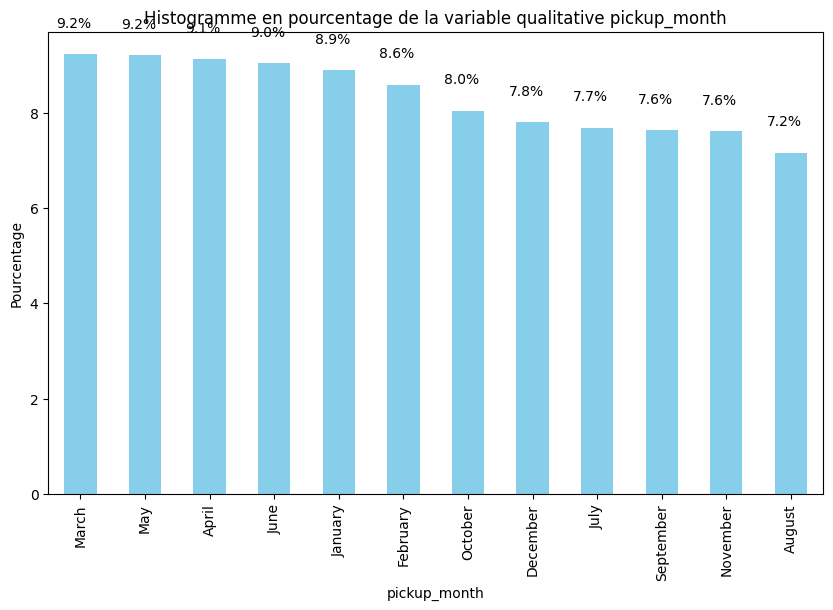

In [389]:
variable_quali = 'pickup_month'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

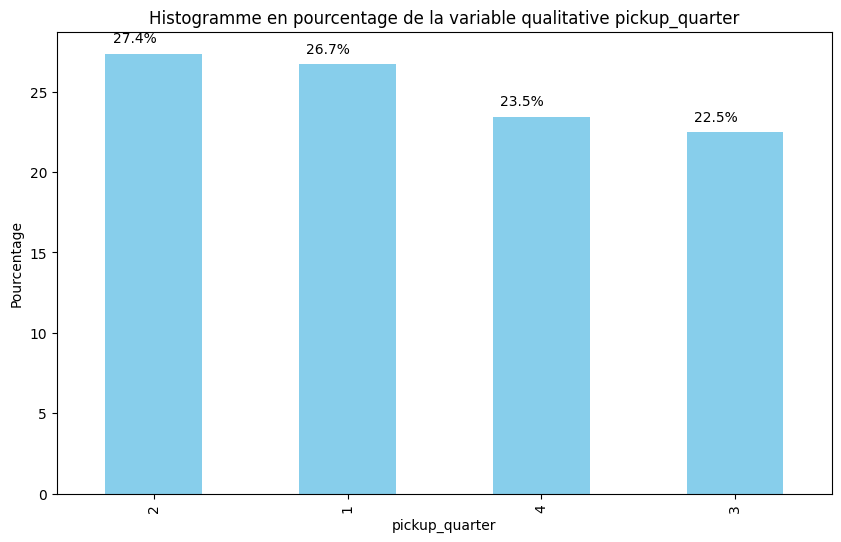

In [390]:
variable_quali = 'pickup_quarter'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

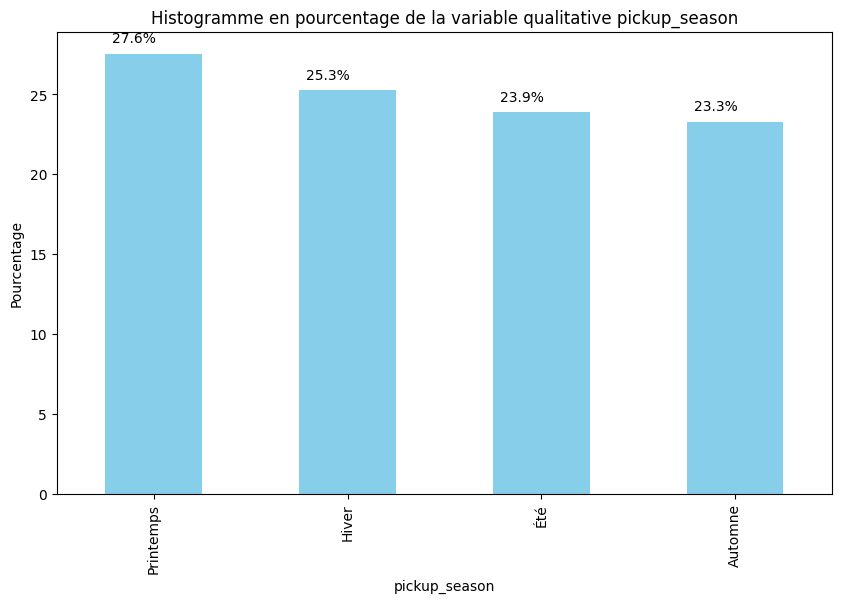

In [391]:
variable_quali = 'pickup_season'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

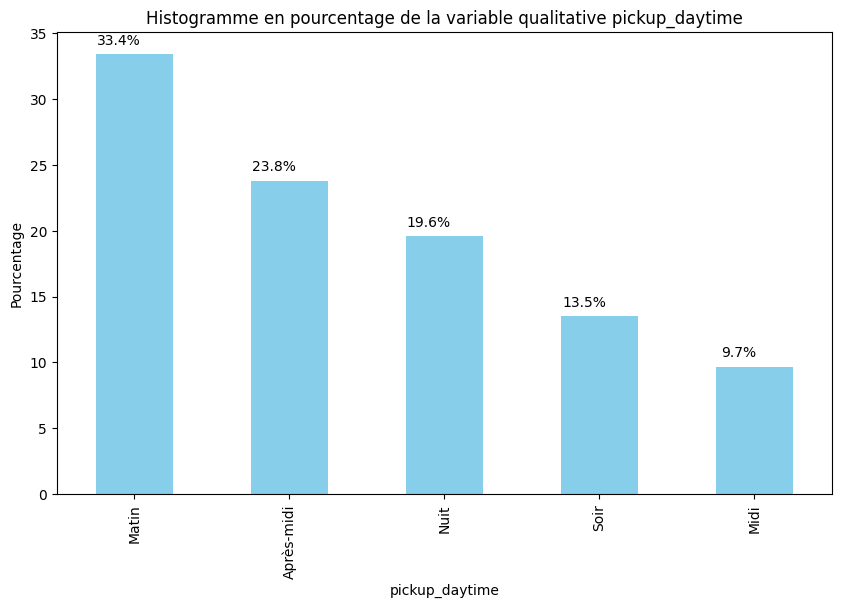

In [392]:
variable_quali = 'pickup_daytime'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

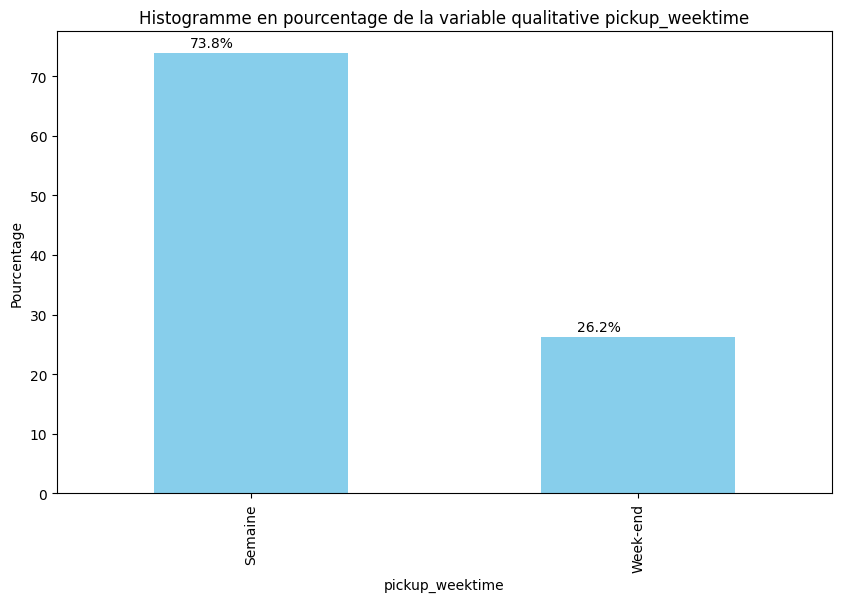

In [393]:
variable_quali = 'pickup_weektime'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

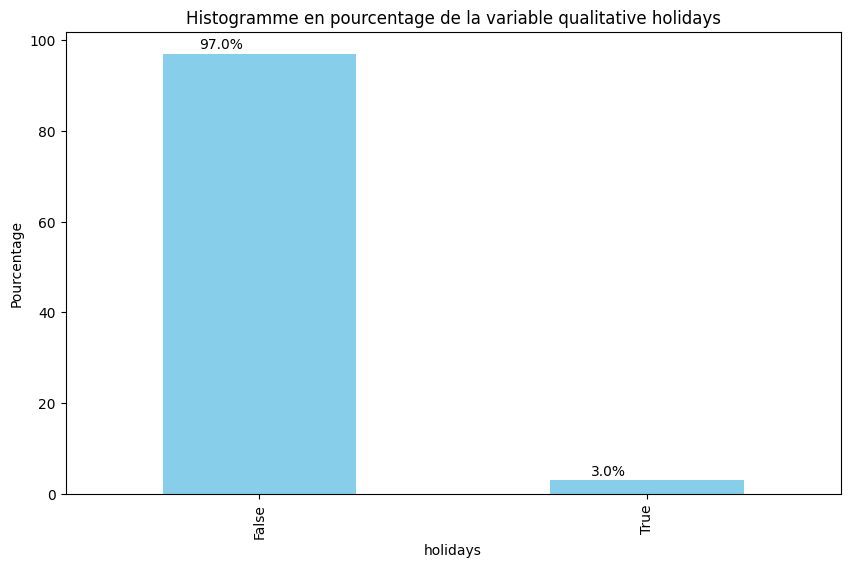

In [394]:
variable_quali = 'holidays'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

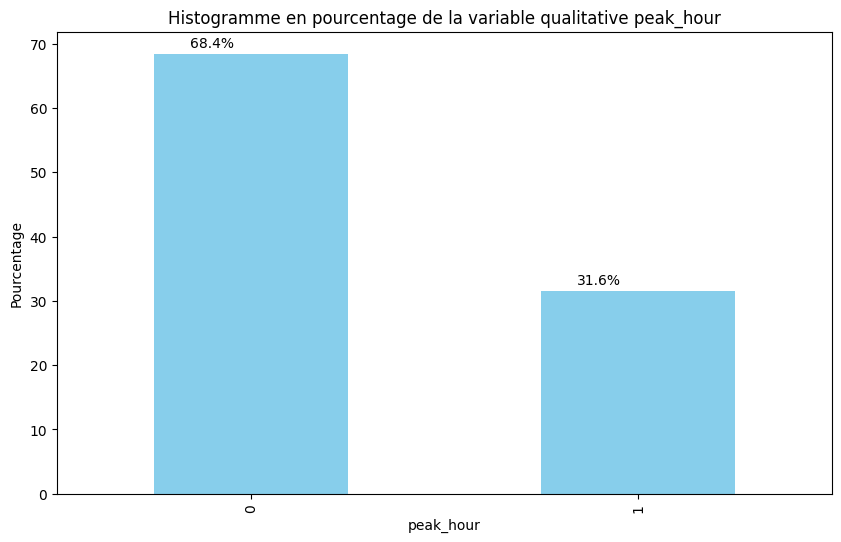

In [395]:
variable_quali = 'peak_hour'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

In [396]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 95844  individus et  17  variables.
